In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from google.colab import files
import io
import pandas as pd
import math 


2.2.0


In [2]:
uploaded = files.upload()

Saving hpq.us.txt to hpq.us.txt


In [0]:
hp = pd.read_csv(io.BytesIO(uploaded['hpq.us.txt']))

In [4]:
hp['Close'].isnull().sum()

0

In [5]:
hp

,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0
...,...,...,...,...,...,...,...
12070,2017-11-06,21.47000,21.53000,21.38000,21.44000,13309476,0
12071,2017-11-07,21.47000,21.47000,21.32000,21.38000,6245536,0
12072,2017-11-08,21.34000,21.47000,21.24000,21.42000,6061868,0
12073,2017-11-09,21.27000,21.40000,21.15000,21.34000,5844935,0


In [0]:
hp['ret'] = hp.Close.pct_change(1).mul(100)

In [7]:
#using returns instead of close price
series = hp['ret']
print(series)
type(series)
time = np.arange(0,12075,1)

print("time_shape :", time.shape)
print("series_shape :", series.shape)


0             NaN
1        2.474940
2       -1.239446
3        1.255001
4        0.000000
           ...   
12070   -0.139730
12071   -0.279851
12072    0.187091
12073   -0.373483
12074   -0.515464
Name: ret, Length: 12075, dtype: float64
time_shape : (12075,)
series_shape : (12075,)


In [0]:
#adjusting series for using return
series = series[1:]


In [0]:
series = pd.Series.to_numpy(series)

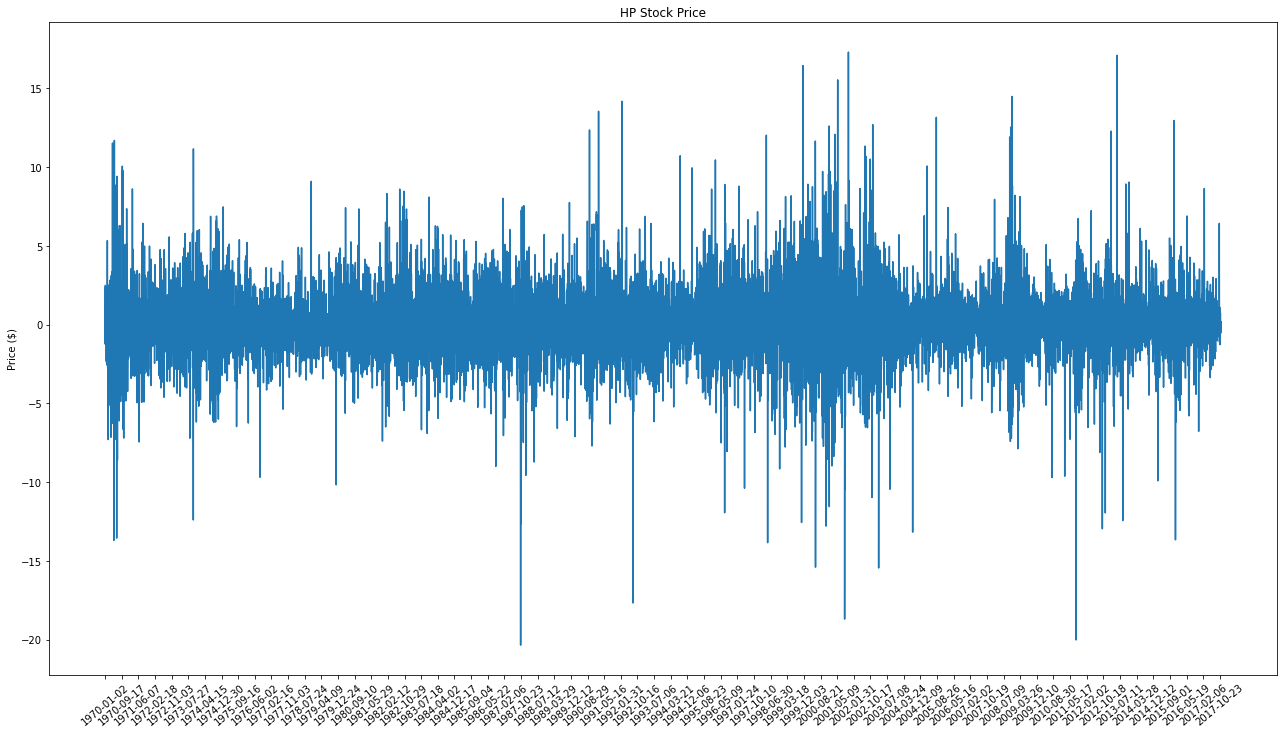

In [10]:
##plot the price
df = hp.copy()
plt.figure(figsize = (22,12))
plt.plot(hp.index, hp['ret'])
plt.title('HP Stock Price')
plt.xticks(range(0,hp.shape[0],180),hp['Date'].loc[::180],rotation=40)
plt.ylabel('Price ($)');
plt.show()


In [11]:
time = np.arange(0,12074,1)
print(series.shape)
print(time.shape)

(12074,)
(12074,)


In [0]:
split_time = 9000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 128
shuffle_buffer_size = 1000

In [13]:
type(x_train)

numpy.ndarray

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
70/70 [==============================] - 1s 19ms/step - loss: 11.7652 - mse: 240.4442 - lr: 1.0000e-08
Epoch 2/100
70/70 [==============================] - 1s 20ms/step - loss: 11.6078 - mse: 234.7892 - lr: 1.1220e-08
Epoch 3/100
70/70 [==============================] - 1s 20ms/step - loss: 11.4355 - mse: 228.6345 - lr: 1.2589e-08
Epoch 4/100
70/70 [==============================] - 1s 20ms/step - loss: 11.2489 - mse: 221.9985 - lr: 1.4125e-08
Epoch 5/100
70/70 [==============================] - 1s 20ms/step - loss: 11.0440 - mse: 214.8030 - lr: 1.5849e-08
Epoch 6/100
70/70 [==============================] - 1s 20ms/step - loss: 10.8179 - mse: 206.9245 - lr: 1.7783e-08
Epoch 7/100
70/70 [==============================] - 1s 20ms/step - loss: 10.5680 - mse: 198.3842 - lr: 1.9953e-08
Epoch 8/100
70/70 [==============================] - 1s 20ms/step - loss: 10.2922 - mse: 189.1142 - lr: 2.2387e-08
Epoch 9/100
70/70 [==============================] - 1s 20ms/step - loss: 9.9874

(1e-08, 0.0001, 0.0, 30.0)

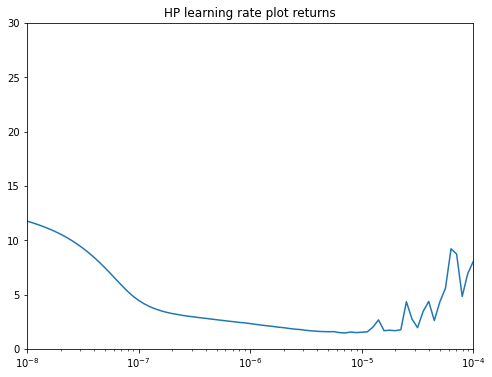

In [22]:
plt.figure(figsize=(8,6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title("HP learning rate plot returns")
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mse"])
history = model.fit(dataset,epochs=300,verbose=1)

Epoch 1/300
70/70 [==============================] - 2s 32ms/step - loss: 4.1947 - mse: 47.9769
Epoch 2/300
70/70 [==============================] - 2s 33ms/step - loss: 2.4262 - mse: 15.2358
Epoch 3/300
70/70 [==============================] - 2s 32ms/step - loss: 1.9661 - mse: 10.9963
Epoch 4/300
70/70 [==============================] - 2s 33ms/step - loss: 1.7464 - mse: 9.0094
Epoch 5/300
70/70 [==============================] - 2s 31ms/step - loss: 1.6249 - mse: 8.0813
Epoch 6/300
70/70 [==============================] - 2s 32ms/step - loss: 1.6954 - mse: 8.4731
Epoch 7/300
70/70 [==============================] - 2s 34ms/step - loss: 1.9442 - mse: 9.8000
Epoch 8/300
70/70 [==============================] - 2s 32ms/step - loss: 1.5992 - mse: 7.6310
Epoch 9/300
70/70 [==============================] - 2s 31ms/step - loss: 1.5325 - mse: 7.3140
Epoch 10/300
70/70 [==============================] - 2s 34ms/step - loss: 1.5509 - mse: 7.2942
Epoch 11/300
70/70 [==========================

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


In [0]:
time_valid.shape

(3074,)

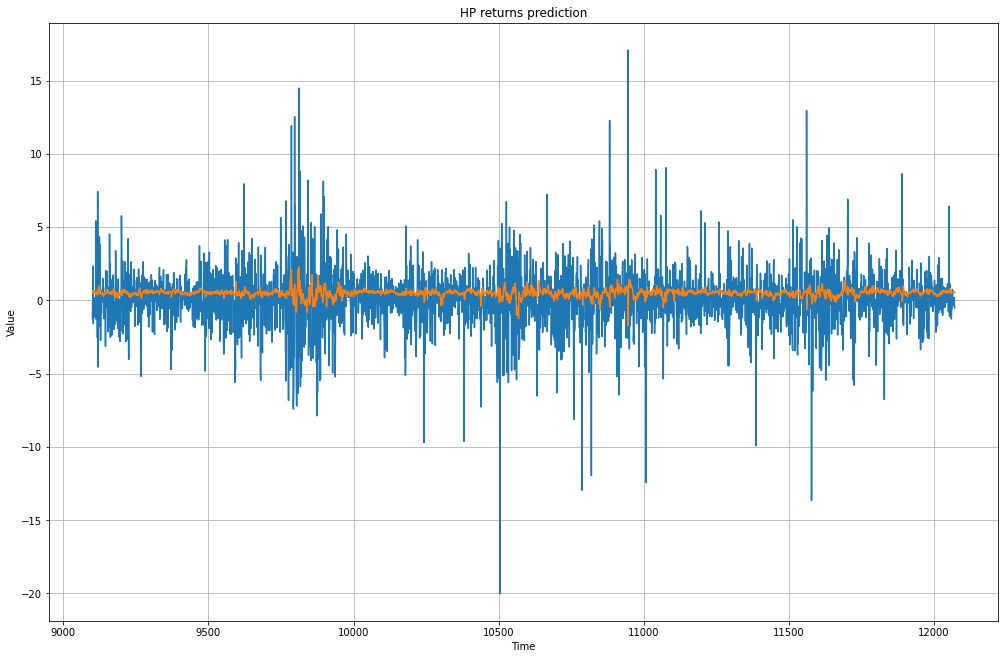

In [0]:
plt.figure(figsize=(17,11))
plt.title("HP returns prediction")
plot_series(time_valid[100:3075], x_valid[100:3075])
plot_series(time_valid[100:3075], results[100:3075])

In [0]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

4.3573604

In [0]:
print("RMSE= " , math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()))

RMSE=  2.087429127660767


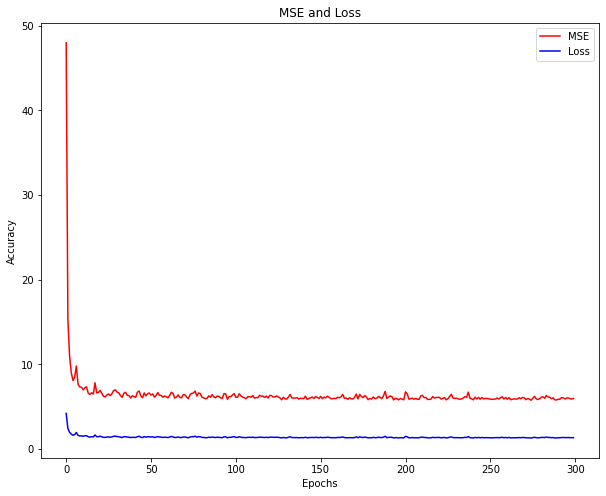

<Figure size 432x288 with 0 Axes>

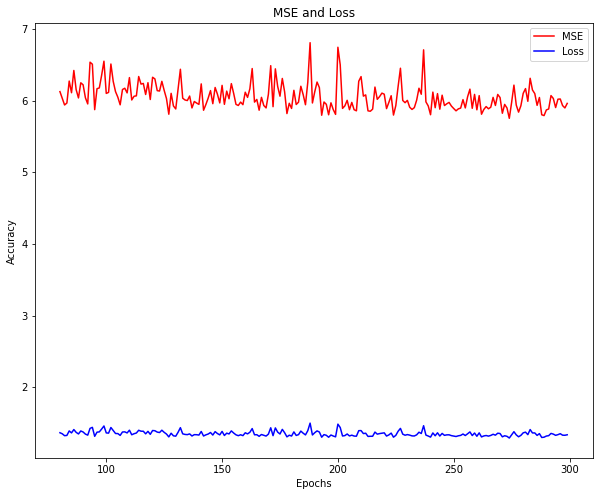

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.figure(figsize=(10,8))
plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()

epochs_zoom = epochs[80:]
mse_zoom = mse[80:]
loss_zoom = loss[80:300]



#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.figure(figsize=(10,8))
plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

